## **Installation et récupération des données**

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from helpers2 import S3Connection

In [3]:
s3 = S3Connection(bucket_name="clichere/diffusion")

Connection successful


In [4]:
path_logements_existants = "DPE/DPE_ADEME/dpe-v2-logements-existants.csv"
DPE_existants = s3.read_csv_from_s3(path_logements_existants)

path_logements_neufs = "DPE/DPE_ADEME/dpe-v2-logements-neufs.csv"
DPE_neufs = s3.read_csv_from_s3(path_logements_neufs)

In [5]:
path_vf_2024 = "valeursfoncieres/vf_2024.csv"
vf_2024 = s3.read_csv_from_s3(path_vf_2024)

path_vf_2023 = "valeursfoncieres/vf_2023.csv"
vf_2023 = s3.read_csv_from_s3(path_vf_2023)

path_vf_2022 = "valeursfoncieres/vf_2022.csv"
vf_2022 = s3.read_csv_from_s3(path_vf_2022)

path_vf_2021 = "valeursfoncieres/vf_2021.csv"
vf_2021 = s3.read_csv_from_s3(path_vf_2021)

path_vf_2020 = "valeursfoncieres/vf_2020.csv"
vf_2020 = s3.read_csv_from_s3(path_vf_2020)

path_vf_2019 = "valeursfoncieres/vf_2019.csv"
vf_2019 = s3.read_csv_from_s3(path_vf_2019)

In [ ]:
vf = pd.concat([vf_2022, vf_2021, vf_2020, vf_2023, vf_2024], ignore_index=True)

## **Fonctions utiles**

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def analyse(df):
    # --- Paramètres généraux ---
    couleurs_dpe = {
        "A": "#006400", "B": "#228B22", "C": "#7CFC00",
        "D": "#FFD700", "E": "#FFA500", "F": "#FF8C00", "G": "#FF0000",
    }

    def statistiques_generales(df):
        print("====== STATISTIQUES GÉNÉRALES ======")
        print(f"Nombre de lignes : {len(df)}")
        total_nan = df.isna().sum().sum()
        print(f"Nombre total de valeurs manquantes (NaN) : {total_nan}")
        top_nan = df.isna().sum().sort_values(ascending=False).head(10)
        print("Top 10 colonnes avec le plus de NaN :\n", top_nan)

    def analyse_colonnes(df):
        print("\n====== ANALYSE PAR COLONNE ======")
        for col in df.columns:
            print(f"\n--- Colonne : {col} ---")
            print(f"Type : {df[col].dtype}")
            print(f"Valeurs uniques : {df[col].nunique()}")
            print(f"Valeurs manquantes : {df[col].isna().sum()}")

            if pd.api.types.is_numeric_dtype(df[col]):
                print("Statistiques descriptives :\n", df[col].describe())
                # Détection des valeurs aberrantes (outliers)
                q1, q3 = df[col].quantile([0.25, 0.75])
                iqr = q3 - q1
                lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
                outliers = df[(df[col] < lower) | (df[col] > upper)]
                print(f"Valeurs aberrantes (méthode IQR) : {len(outliers)}")
            elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
                print("Top modalités :\n", df[col].value_counts(dropna=False).head(10))

    def histogramme_dpe(df):
        print("\n====== HISTOGRAMME DPE GÉNÉRAL ======")
        dpe_counts = df["Etiquette_DPE"].value_counts(normalize=True).reindex(["A", "B", "C", "D", "E", "F", "G"]) * 100
        colors = [couleurs_dpe.get(dpe, "grey") for dpe in dpe_counts.index]

        fig, ax = plt.subplots(figsize=(8, 5))
        bars = ax.bar(dpe_counts.index, dpe_counts.values, color=colors)
        ax.set_title("Répartition des étiquettes DPE")
        ax.set_xlabel("Étiquette DPE")
        ax.set_ylabel("Pourcentage")
        for bar in bars:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.2f}%", ha='center')
        plt.tight_layout()
        plt.show()

    def analyse_par_departement(df):
        print("\n====== ANALYSE PAR DÉPARTEMENT ======")
        df_dep = df.copy()
        df_dep["N°_département_(BAN)"] = pd.to_numeric(df_dep["N°_département_(BAN)"], errors="coerce")
        df_dep = df_dep[df_dep["N°_département_(BAN)"] <= 101]
        df_dep["N°_département_(BAN)"] = df_dep["N°_département_(BAN)"].astype(int).astype(str).str.zfill(2)

        repartition = df_dep.groupby("N°_département_(BAN)")["Etiquette_DPE"].value_counts(normalize=True).unstack() * 100
        print("Pourcentage d'étiquettes DPE par département :\n", repartition)

        for dep in ["75", "92", "13", "44"]:
            if dep in repartition.index:
                dpe_values = repartition.loc[dep].reindex(["A", "B", "C", "D", "E", "F", "G"])
                colors = [couleurs_dpe.get(k, "grey") for k in dpe_values.index]
                plt.figure()
                bars = plt.bar(dpe_values.index, dpe_values.values, color=colors)
                plt.title(f"DPE - Département {dep}")
                plt.ylabel("Pourcentage")
                plt.xlabel("Étiquette DPE")
                for bar in bars:
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.2f}%", ha='center')
                plt.tight_layout()
                plt.show()

        dep_A = df_dep[df_dep["Etiquette_DPE"] == "A"]["N°_département_(BAN)"].value_counts().idxmax()
        dep_G = df_dep[df_dep["Etiquette_DPE"] == "G"]["N°_département_(BAN)"].value_counts().idxmax()
        print(f"Département avec le plus de logements en A : {dep_A}")
        print(f"Département avec le plus de logements en G : {dep_G}")

    def analyse_par_type_batiment(df):
        print("\n====== ANALYSE PAR TYPE DE BÂTIMENT ======")
        types = df["Type_bâtiment"].value_counts()
        print("Types de bâtiments présents :\n", types)

        plt.figure(figsize=(5, 5))
        plt.pie(types, labels=types.index, autopct='%1.1f%%', startangle=90,
                colors=["#6495ED", "#87CEFA", "#1E90FF"])
        plt.title("Répartition par type de bâtiment")
        plt.axis('equal')
        plt.show()

        tableau = df.groupby(["Type_bâtiment", "Etiquette_DPE"]).size().unstack(fill_value=0)
        pourcentages = (tableau.T / tableau.sum(axis=1)).T * 100
        print("Pourcentage d’étiquettes DPE par type de bâtiment :\n", pourcentages)

        type_max_A = df[df["Etiquette_DPE"] == "A"]["Type_bâtiment"].value_counts().idxmax()
        type_max_E = df[df["Etiquette_DPE"] == "E"]["Type_bâtiment"].value_counts().idxmax()
        print(f"Type de bâtiment avec le plus de logements en A : {type_max_A}")
        print(f"Type de bâtiment avec le plus de logements en E : {type_max_E}")

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        for i, t in enumerate(['appartement', 'immeuble', 'maison']):
            if t in pourcentages.index:
                dpe_vals = pourcentages.loc[t].reindex(["A", "B", "C", "D", "E", "F", "G"])
                colors = [couleurs_dpe.get(dpe, "grey") for dpe in dpe_vals.index]
                bars = axes[i].bar(dpe_vals.index, dpe_vals.values, color=colors)
                axes[i].set_title(f"{t.capitalize()} - Répartition DPE")
                axes[i].set_ylabel("Pourcentage")
                axes[i].set_xlabel("Étiquette DPE")
                for bar in bars:
                    axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.1f}%", ha='center')
        plt.tight_layout()
        plt.show()

    # --- Appels des fonctions ---
    statistiques_generales(df)
    analyse_colonnes(df)
    histogramme_dpe(df)
    analyse_par_departement(df)
    analyse_par_type_batiment(df)


## **Analyse**

====== STATISTIQUES GÉNÉRALES ======
Nombre de lignes : 4537525
Nombre total de valeurs manquantes (NaN) : 17334637
Top 10 colonnes avec le plus de NaN :
 Cage_d'escalier                  4473586
Nom_résidence                    4187600
Complément_d'adresse_bâtiment    2567157
Complément_d'adresse_logement    2195128
Année_construction               1484043
N°_étage_appartement             1145452
N°_voie_(BAN)                     630304
Nom__rue_(BAN)                    347796
Surface_habitable_logement         52267
Adresse_(BAN)                      29373
dtype: int64

====== ANALYSE PAR COLONNE ======

--- Colonne : Date_réception_DPE ---
Type : object
Valeurs uniques : 697
Valeurs manquantes : 0
Top modalités :
 Date_réception_DPE
2023-02-23    16943
2023-05-03    16649
2023-05-25    16603
2023-02-27    16593
2023-05-22    16004
2023-04-24    15988
2023-03-30    15550
2023-03-23    15492
2023-04-26    15337
2023-02-28    15320
Name: count, dtype: int64

--- Colonne : Date_établiss

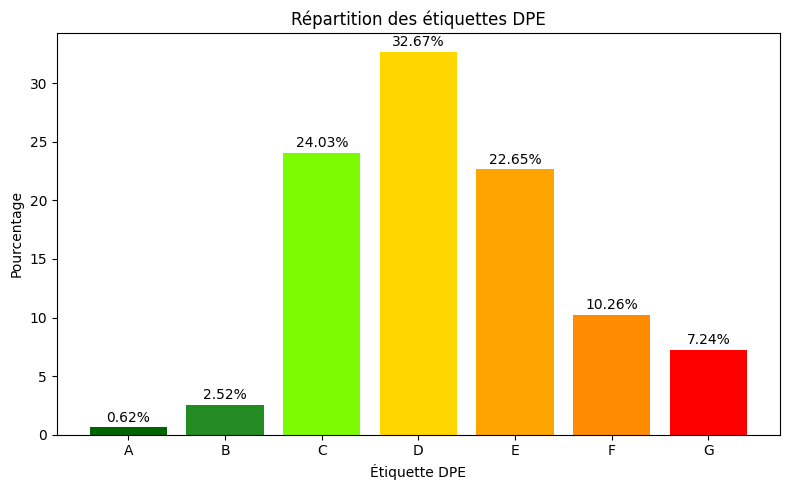


====== ANALYSE PAR DÉPARTEMENT ======
Pourcentage d'étiquettes DPE par département :
 Etiquette_DPE                A         B          C          D          E  \
N°_département_(BAN)                                                        
01                    0.802581  2.605055  23.866788  33.951045  21.776344   
02                    0.114247  0.868274  11.599832  29.806923  31.612019   
03                    0.543066  3.165783  16.224636  28.774101  23.890713   
04                    0.126029  1.218283   9.368173  23.382625  31.129222   
05                    0.097238  0.729288   5.562038  20.507585  39.294049   
...                        ...       ...        ...        ...        ...   
91                    0.167254  1.567409  28.645840  34.567827  20.753838   
92                    0.127695  1.346371  19.371979  29.419629  25.822735   
93                    0.037153  1.376839  25.074852  32.434382  23.117774   
94                    0.103819  2.442137  23.670826  29.821888  25

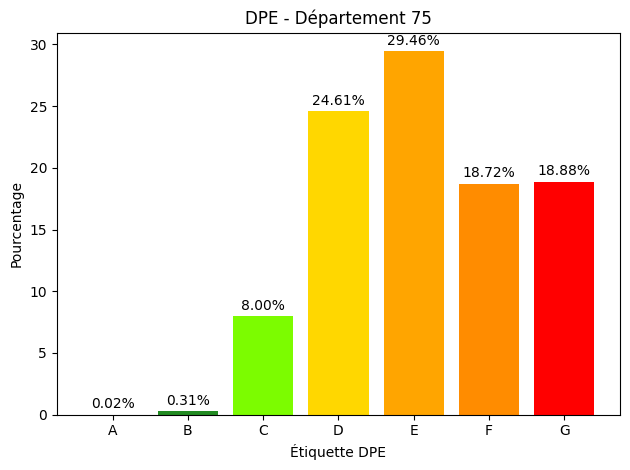

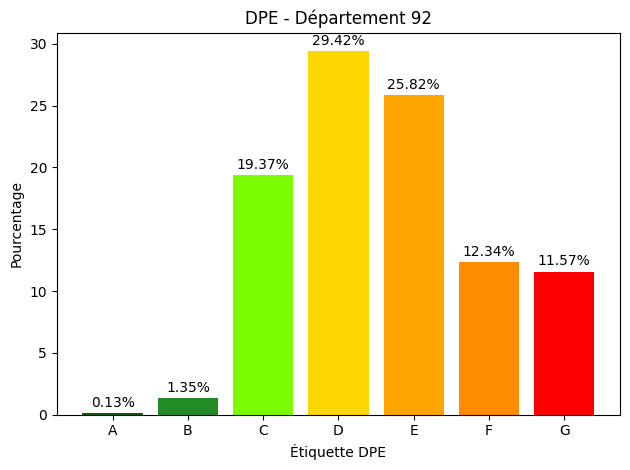

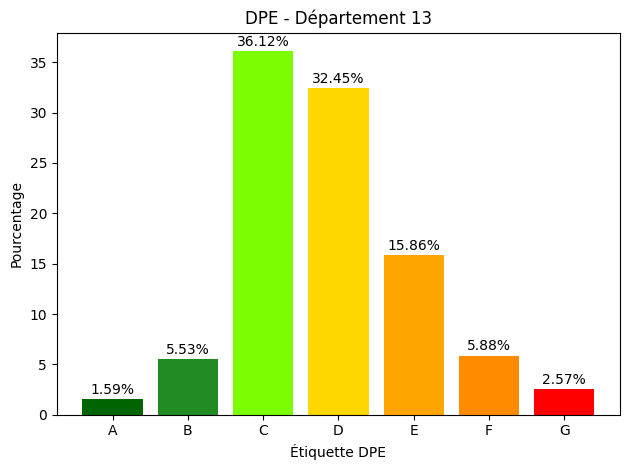

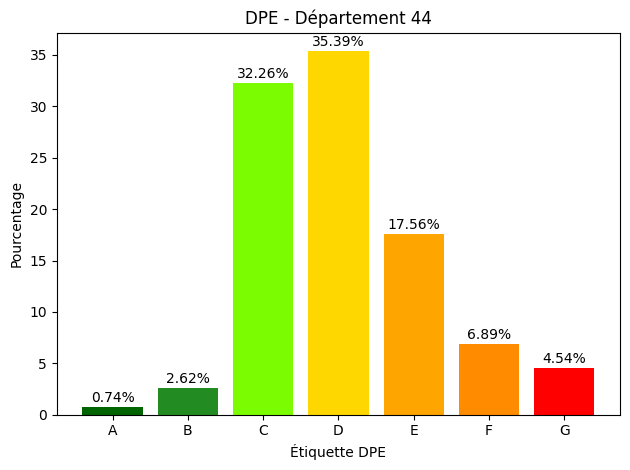

Département avec le plus de logements en A : 13
Département avec le plus de logements en G : 75

====== ANALYSE PAR TYPE DE BÂTIMENT ======
Types de bâtiments présents :
 Type_bâtiment
appartement    2924550
maison         1563858
immeuble         49117
Name: count, dtype: int64


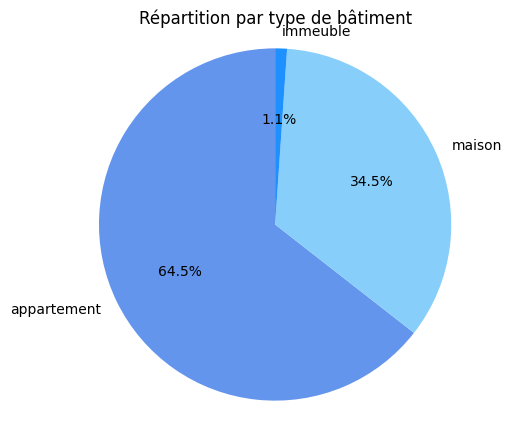

Pourcentage d’étiquettes DPE par type de bâtiment :
 Etiquette_DPE         A         B          C          D          E          F  \
Type_bâtiment                                                                   
appartement    0.296046  2.137867  26.848233  33.808005  21.924775   8.913029   
immeuble       0.232099  2.209011  36.062870  33.851823  17.936763   6.380683   
maison         1.250497  3.257841  18.387475  30.510187  24.156157  12.904816   

Etiquette_DPE         G  
Type_bâtiment            
appartement    6.072045  
immeuble       3.326750  
maison         9.533027  
Type de bâtiment avec le plus de logements en A : maison
Type de bâtiment avec le plus de logements en E : appartement


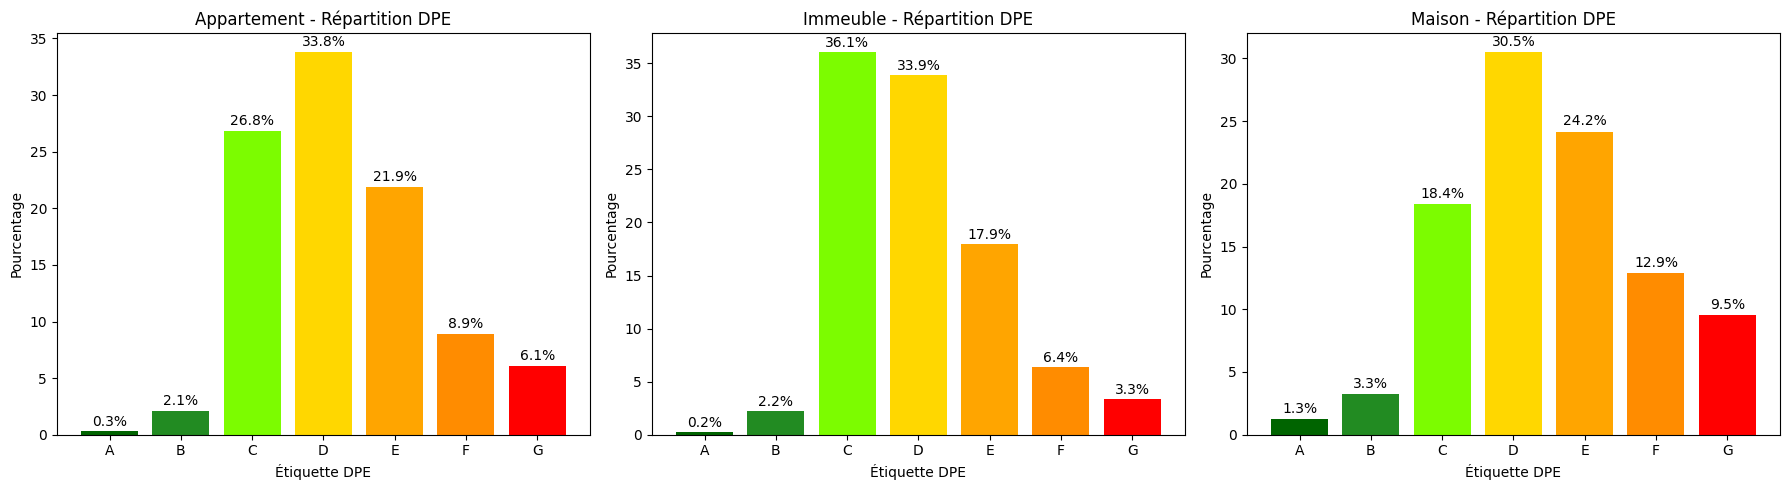

In [11]:
analyse(DPE_existants)